positions (1000, 2) activations (1000, 100)
Spatial info (bits/spike): [0.1251, 0.1245, 0.1253, 0.1249, 0.126, 0.1251, 0.1244, 0.1253, 0.1253, 0.125, 0.124, 0.1228, 0.1238, 0.1251, 0.1242, 0.1247, 0.1241, 0.1247, 0.124, 0.1236, 0.1235, 0.1251, 0.1252, 0.1241, 0.1251, 0.1255, 0.1248, 0.1256, 0.1236, 0.1242, 0.1263, 0.127, 0.1252, 0.1264, 0.1232, 0.1246, 0.1259, 0.1245, 0.1255, 0.1249, 0.125, 0.1257, 0.1245, 0.1245, 0.1249, 0.1224, 0.1236, 0.1239, 0.1236, 0.1228]
Sparsity scores: [0.8771, 0.8772, 0.8769, 0.8772, 0.8759, 0.8771, 0.8776, 0.8769, 0.8768, 0.8772, 0.8781, 0.8793, 0.8782, 0.8771, 0.8778, 0.8775, 0.8779, 0.8771, 0.8781, 0.8784, 0.8785, 0.8771, 0.8771, 0.8779, 0.8771, 0.8767, 0.8771, 0.8765, 0.8784, 0.8779, 0.8761, 0.8754, 0.877, 0.8756, 0.8788, 0.8776, 0.8761, 0.8778, 0.8765, 0.8772, 0.877, 0.8761, 0.8777, 0.8774, 0.8769, 0.8795, 0.8783, 0.8781, 0.8784, 0.8791]
Selected indices (info>0.09): [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28

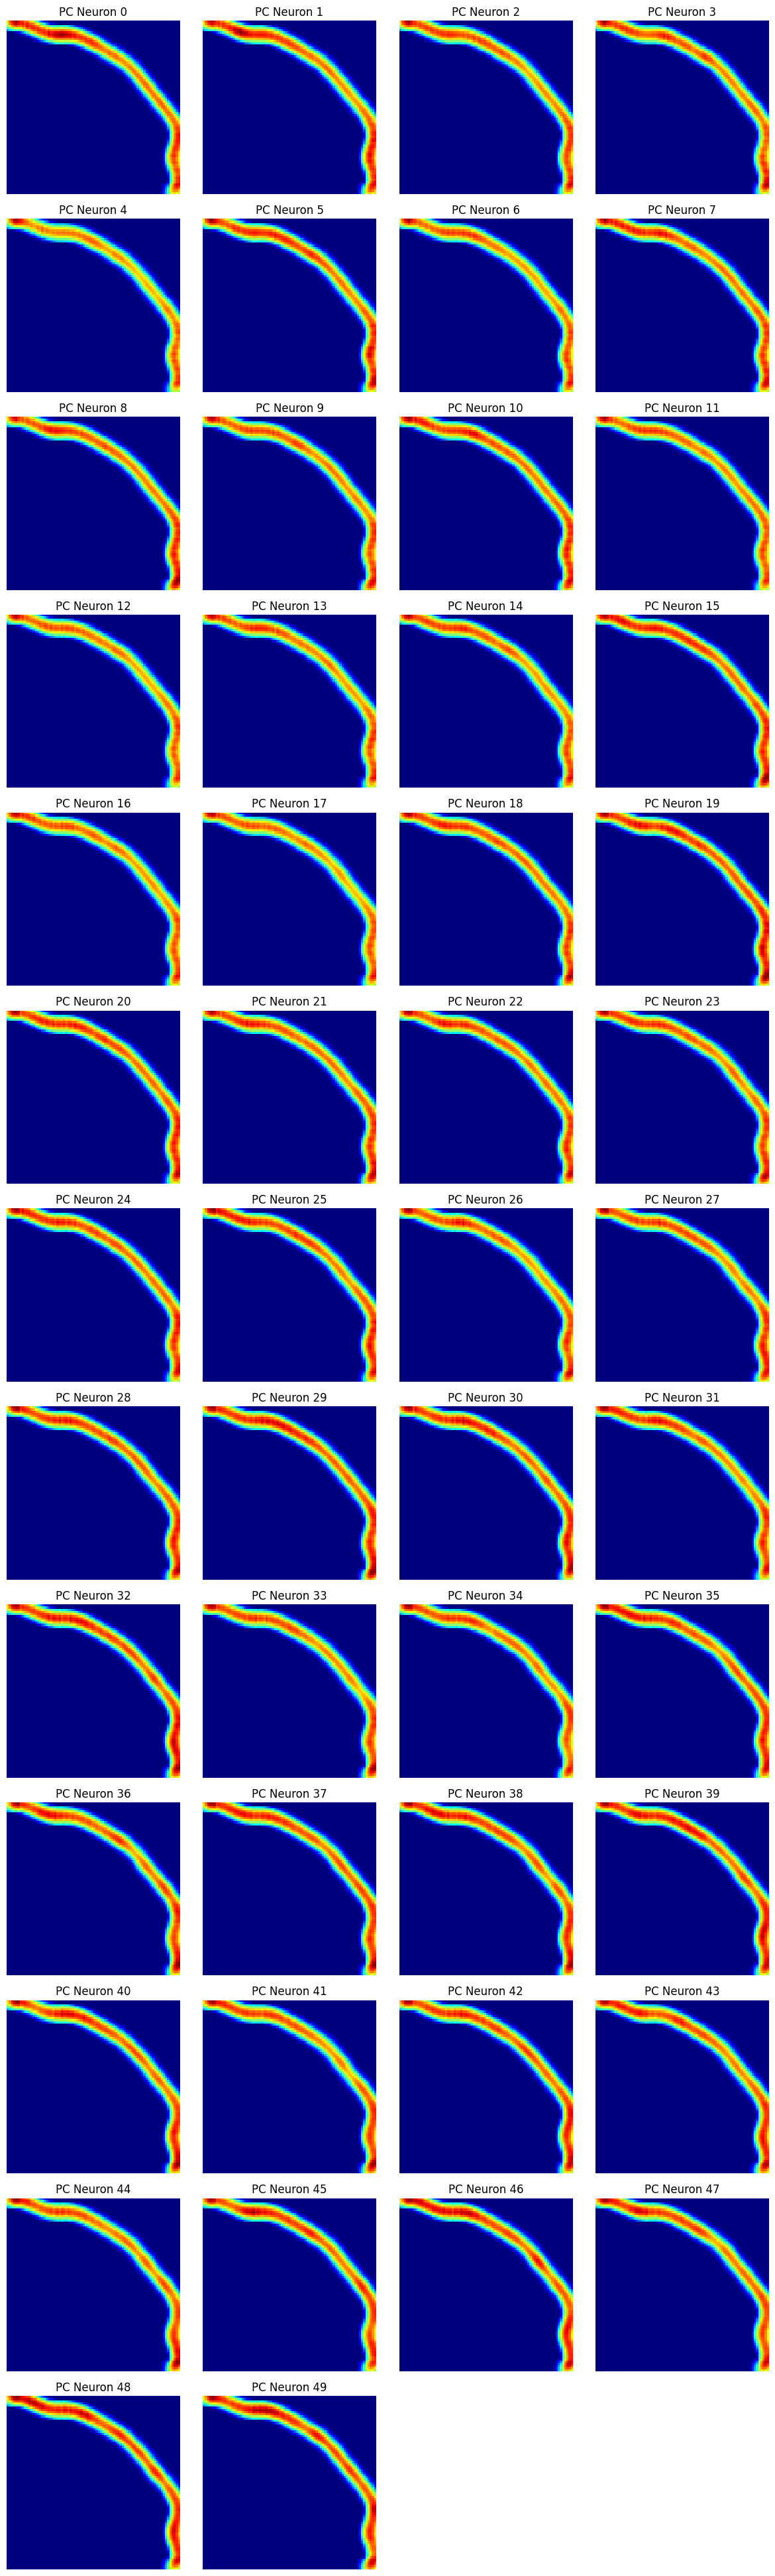

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import scipy, pickle
import scipy.signal
from tqdm import tqdm
from scipy import ndimage
import math


epsilon = 1e-10

# thresholds (you can tune these)
lim = 0.0              # threshold multiplier for spike selection (mean + lim * std). Set low to avoid empty spikes.
reso = 40              # resolution parameter (bins per axis will be reso*2)
spi_threshold = 0.093
spar_threshold = 0.95

# -------------------------
# I/O and quick helpers
# -------------------------
def get_input_data(activation_path, trajectory_path):
    """Load trajectory dict {'x':..., 'y':...} and activation array (T,N) or (N,T)."""
    with open(trajectory_path, 'rb') as f:
        data_pos = pickle.load(f)

    with open(activation_path, 'rb') as f:
        activations = pickle.load(f)

    x = np.asarray(data_pos['x'])
    y = np.asarray(data_pos['y'])
    positions = np.column_stack((x, y))
    # Ensure activations are numpy and shape (T, N)
    activations = np.asarray(activations)
    if activations.ndim == 2 and activations.shape[0] != positions.shape[0]:
        activations = activations.T
    return positions, activations

# -------------------------
# gaussian kernel
# -------------------------
def matlab_style_gauss2D(shape=(9, 9), sigma=3):
    m, n = [(ss - 1.) / 2. for ss in shape]
    y, x = np.ogrid[-m:m+1, -n:n+1]
    h = np.exp(-(x*x + y*y) / (2. * sigma * sigma))
    h[h < np.finfo(h.dtype).eps * h.max()] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h

# -------------------------
# occupancy (2D)
# -------------------------
def occupancy_map_func(pos, reso=40, win_len=21):
    """
    pos: (T,2) array
    returns: occ_prob (2D), xedges, yedges, occ_counts (raw H)
    occ_prob has zeros where no visits; for plotting we may set NaN externally.
    """
    x = pos[:, 0]
    y = pos[:, 1]
    bins = (reso*2, reso*2)

    # Build raw histogram counts
    H, xedges, yedges = np.histogram2d(x, y, bins=bins)

    # Smooth raw counts
    gaussian = matlab_style_gauss2D((win_len, win_len), sigma=6.0)
    H_smooth = scipy.signal.convolve2d(H, gaussian, mode='same', boundary='fill', fillvalue=0)

    # Convert to probability (sum to 1)
    total = np.nansum(H_smooth)
    if total <= 0:
        occ_prob = H_smooth.copy()
    else:
        occ_prob = H_smooth / (total + epsilon)

    # Do NOT convert zeros into NaN for math. Return occ_prob (zeros allowed).
    # For plotting, caller can mask zeros to NaN if desired.
    return occ_prob, xedges, yedges, H_smooth

# -------------------------
# firing rate map (2D)
# -------------------------
def firing_rate_map_2d(resp_neurons, positions, occ_tuple, thresh_param=0.0, res_param=40, show_plot=False, title=""):
    """
    Compute 2D firing-rate map (smoothed) for one neuron.
    - resp_neurons: (T,) activations
    - positions: (T,2)
    - occ_tuple: (occ_prob, xedges, yedges, H_raw)
    Returns:
      fr_map_smooth: 2D array same shape as occ_prob (rate)
      fr_map_norm: normalized 0-1 (for visualization)
      spike_positions: array of positions where resp > threshold
    """
    occ_prob, xedges, yedges, H_raw = occ_tuple
    T = positions.shape[0]

    # threshold to pick "spikes" or strong activations
    mean_resp = np.nanmean(resp_neurons)
    std_resp = np.nanstd(resp_neurons)
    thresh = mean_resp + (thresh_param * std_resp)

    spike_idx = np.where(resp_neurons > thresh)[0]
    spike_pos = positions[spike_idx]  # shape (Ns,2) possibly empty

    # Compute spike-count histogram using the same bin edges
    # Note: np.histogram2d takes x,y and bins = [x_edges, y_edges]
    if spike_pos.shape[0] == 0:
        H_spikes = np.zeros_like(occ_prob)
    else:
        H_spikes, xe_s, ye_s = np.histogram2d(spike_pos[:,0], spike_pos[:,1], bins=[xedges, yedges])

    # Convert occupancy probability (occ_prob) into counts-like occupancy for division:
    # We need occupancy in time/visits units — H_raw is smoothed counts; use H_raw directly
    occ_counts = H_raw.copy()  # may have zeros where not visited

    # Rate map: spike counts divided by occupancy counts (per-bin). Use epsilon to protect.
    fr_map = H_spikes / (occ_counts + epsilon)

    # Smooth firing map with Gaussian kernel
    gaussian = matlab_style_gauss2D((9,9), sigma=3.0)
    fr_map_smooth = scipy.signal.convolve2d(fr_map, gaussian, mode='same', boundary='fill', fillvalue=0)

    # For bins with zero occupancy, set to NaN for plotting but keep zeros for math
    fr_map_smooth_plot = fr_map_smooth.copy()
    fr_map_smooth_plot[occ_counts == 0] = np.nan

    # Normalized map for visualization
    finite_vals = fr_map_smooth[occ_counts > 0]
    if finite_vals.size == 0:
        fr_map_norm = fr_map_smooth_plot
    else:
        mn, mx = finite_vals.min(), finite_vals.max()
        if mx - mn < 1e-12:
            fr_map_norm = fr_map_smooth_plot - mn
        else:
            fr_map_norm = (fr_map_smooth_plot - mn) / (mx - mn)

    if show_plot:
        plt.figure(figsize=(4,4))
        plt.imshow(np.rot90(fr_map_smooth_plot), origin='lower', cmap='jet')
        plt.title(title)
        plt.colorbar()
        plt.show()

    return fr_map_smooth, fr_map_norm, spike_pos, occ_counts

# -------------------------
# information / sparsity (2D)
# -------------------------
def inf_rate(rate_map, occ_counts):
    """
    Compute spatial information (bits per spike) following Skaggs:
      I = sum_x p(x) * (r(x)/r_bar) * log2( r(x)/r_bar )
    where p(x) is occupancy probability and r(x) is firing rate at bin x.
    Inputs:
      rate_map: 2D array of firing rates (not masked) — should have meaningful values (zeros allowed)
      occ_counts: 2D raw occupancy counts (smoothed) used to derive p(x)
    Returns:
      information (float), avg_rate (float)
    """
    # Build occupancy probability px from occ_counts
    occ_counts = np.array(occ_counts, dtype=float)
    total = np.nansum(occ_counts)
    if total <= 0:
        return 0.0, 0.0
    px = occ_counts / (total + epsilon)  # px sums to 1

    # rate_map: ensure same shape
    rate = np.array(rate_map, dtype=float)
    # set NaNs to zero for math
    rate_flat = rate.copy()
    rate_flat[np.isnan(rate_flat)] = 0.0

    avg_rate = np.sum(rate_flat * px)

    if avg_rate <= 0:
        return 0.0, avg_rate

    # compute information
    ratio = np.zeros_like(rate_flat)
    nonzero_mask = rate_flat > 0
    ratio[nonzero_mask] = rate_flat[nonzero_mask] / (avg_rate + epsilon)

    info_map = np.zeros_like(rate_flat)
    info_map[nonzero_mask] = ratio[nonzero_mask] * np.log2(np.maximum(ratio[nonzero_mask], epsilon))

    info = np.nansum(info_map * px)
    return float(info), float(avg_rate)

def sparsity_func(occ_prob, firing_rate):
    """
    Sparsity measure for 2D map.
    occ_prob: occupancy probability (sum to 1) — can be occ_counts/total
    firing_rate: firing-rate map (2D); NaNs allowed
    """
    px = np.array(occ_prob, dtype=float)
    # guard: set NaNs in px to zero and renormalize
    px[np.isnan(px)] = 0.0
    s = np.nansum(px)
    if s <= 0:
        return 0.0
    pos_prob2 = px / (s + epsilon)

    fr = firing_rate.copy()
    fr[np.isnan(fr)] = 0.0

    avg_rate = np.nansum(fr * pos_prob2)
    numerator = avg_rate ** 2
    denominator = np.nansum(pos_prob2 * (fr**2)) + epsilon
    return float(numerator / denominator)

# -------------------------
# get_scores (2D)
# -------------------------
def get_scores(positions, activations, reso=40, lim_local=lim, show_each=False):
    """
    positions: (T,2)
    activations: (T,N)
    Returns:
      spatial_info (list), sparsity_scores (list), spike_pos_all (list), fr_maps_all (list)
    """
    # occupancy
    occ_prob, xedges, yedges, H_raw = occupancy_map_func(positions, reso=reso, win_len=9)
    occ_tuple = (occ_prob, xedges, yedges, H_raw)

    num_neurons = activations.shape[1]
    spatial_info = []
    sparsity_scores = []
    spike_pos_all = []
    fr_maps_all = []

    for i in range(num_neurons):
        resp = activations[:, i]
        fr_map, fr_norm, spike_pos, occ_counts = firing_rate_map_2d(resp, positions, occ_tuple, thresh_param=lim_local, res_param=reso, show_plot=show_each, title=f"Neuron {i}")
        fr_maps_all.append(fr_map)
        spike_pos_all.append(spike_pos)

        # info rate & sparsity
        info, avg_rate = inf_rate(fr_map, occ_counts)
        # If avg_rate == 0 or info nan, set to 0
        if math.isnan(info) or avg_rate == 0:
            info = 0.0
        spatial_info.append(round(info, 4))

        # sparsity uses occ_prob and fr_map (use fr_map with NaNs masked where occ_counts==0)
        occ_prob_for_s = occ_counts.copy()
        occ_prob_for_s[occ_prob_for_s < 0] = 0  # safety
        # convert occ_counts to probability
        tot = np.nansum(occ_prob_for_s)
        occ_prob_norm = occ_prob_for_s / (tot + epsilon)
        spars = sparsity_func(occ_prob_norm, fr_map)
        sparsity_scores.append(round(spars, 4))

    return spatial_info, sparsity_scores, spike_pos_all, fr_maps_all, (xedges, yedges)

# -------------------------
# identify_place_cells (unchanged logic)
# -------------------------
def identify_place_cells(spatial_info, sparsity_scores, spi_threshold=spi_threshold, spar_threshold=spar_threshold):
    selected_spinfo = np.where(np.asarray(spatial_info) > spi_threshold)[0]
    selected_spars = np.where(np.asarray(sparsity_scores) < spar_threshold)[0]
    sel = list(set(selected_spinfo).intersection(set(selected_spars)))
    sel_sorted = sorted(sel)
    print("Selected indices (info>%.2f): %s" % (spi_threshold, selected_spinfo))
    print("Selected indices (spars<%.2f): %s" % (spar_threshold, selected_spars))
    print("Intersection (place cells):", sel_sorted)
    return sel_sorted

def get_scores_by_place_cells(place_cells, spatial_info, sparsity_scores):
    place_cells_indices = place_cells
    place_cells_spatial = [spatial_info[i] for i in place_cells]
    place_cells_sparsity = [sparsity_scores[i] for i in place_cells]
    return {'place_cells_indices': place_cells_indices,
            'spatial_info': place_cells_spatial,
            'sparsity_scores': place_cells_sparsity}

# -------------------------
# plotting helpers
# -------------------------
def plot_place_field(fr_map, title="", cmap='jet'):
    plt.figure(figsize=(4,4))
    # mask zeros where occupancy was zero? caller should have set NaN for plotting
    plt.imshow(np.rot90(fr_map), origin='lower', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.show()

def plot_all_place_fields(fr_maps_all, place_cells=None, cols=5, title_prefix=""):
    if place_cells is None:
        indices = range(len(fr_maps_all))
    else:
        indices = place_cells
    num = len(indices)
    rows = int(np.ceil(num / cols))
    plt.figure(figsize=(3*cols, 3*rows))
    for k, idx in enumerate(indices):
        plt.subplot(rows, cols, k+1)
        plt.imshow(np.rot90(fr_maps_all[idx]), origin='lower', cmap='jet')
        plt.title(f"{title_prefix}Neuron {idx}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# -------------------------
# Minimal usage example
# -------------------------
if __name__ == "__main__":

    # Example: load your data files
    activation_path = '0_input_data/activations_z3_traj_5.pkl'
    trajectory_path = '0_input_data/traj_5_data.pkl'

    positions, activations = get_input_data(activation_path, trajectory_path)
    print("positions", positions.shape, "activations", activations.shape)

    # optionally reduce neurons
    activations = activations[:, :50]

    # compute scores (set show_each=False to avoid plotting each map)
    spatial_info, sparsity_scores, spike_pos_all, fr_maps_all, edges = get_scores(positions, activations, reso=reso, lim_local=lim, show_each=False)

    print("Spatial info (bits/spike):", spatial_info)
    print("Sparsity scores:", sparsity_scores)

    place_cells = identify_place_cells(spatial_info, sparsity_scores, spi_threshold=spi_threshold, spar_threshold=spar_threshold)
    pc_dict = get_scores_by_place_cells(place_cells, spatial_info, sparsity_scores)
    print("Place cell dict:", pc_dict)

    # plot place fields for identified place cells
    if len(place_cells) > 0:
        plot_all_place_fields(fr_maps_all, place_cells=place_cells, cols=4, title_prefix="PC ")
    else:
        print("No place cells found with current thresholds. Consider lowering 'lim' or thresholds.")

# End of script


In [2]:
def plot_combined_place_fields(fr_maps_all, place_cells, alpha=0.35):
    """
    Overlay all place fields of selected neurons in one 2D grid.
    Similar to overlapping circular fields in literature plots.
    """
    combined = np.zeros_like(fr_maps_all[0])
    plt.figure(figsize=(5,5))
    for i in place_cells:
        fr_map = fr_maps_all[i]
        # normalize to [0,1] for visualization
        finite_vals = fr_map[np.isfinite(fr_map)]
        if len(finite_vals) == 0:
            continue
        fr_norm = (fr_map - np.nanmin(finite_vals)) / (np.nanmax(finite_vals) - np.nanmin(finite_vals) + 1e-10)
        plt.imshow(np.rot90(fr_norm), origin='lower', cmap='jet', alpha=alpha)
    plt.title("Overlapping 2D Place Fields")
    plt.axis('off')
    plt.show()


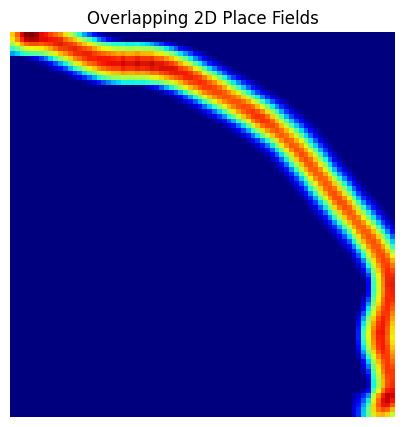

In [3]:
plot_combined_place_fields(fr_maps_all, place_cells)


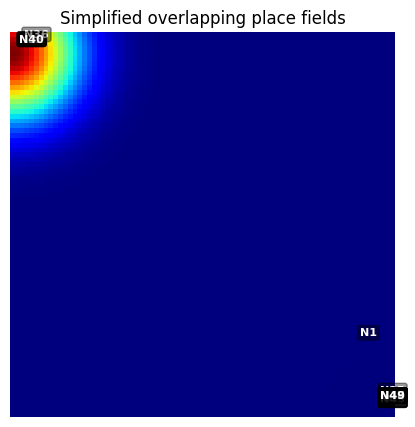

In [4]:
def plot_simplified_fields(fr_maps_all, place_cells, alpha=0.4, sigma=3):
    plt.figure(figsize=(5,5))
    for i in place_cells:
        fr_map = np.nan_to_num(fr_maps_all[i])

        # find peak
        peak_idx = np.unravel_index(np.argmax(fr_map), fr_map.shape)
        x, y = peak_idx

        # create circular Gaussian patch
        rr, cc = np.meshgrid(np.arange(fr_map.shape[0]), np.arange(fr_map.shape[1]))
        mask = np.exp(-((rr - x)**2 + (cc - y)**2) / (2 * sigma**2))

        # plot Gaussian patch
        plt.imshow(np.rot90(mask), origin='lower', cmap='jet', alpha=alpha, vmin=0, vmax=1)

        # add neuron label at the peak
        plt.text(
            fr_map.shape[1] - y - 1,  # adjust for rot90
            x,
            f"N{i}",
            color='white',
            fontsize=8,
            ha='center',
            va='center',
            weight='bold',
            bbox=dict(facecolor='black', alpha=0.4, boxstyle='round,pad=0.2')
        )

    plt.title("Simplified overlapping place fields")
    plt.axis('off')
    plt.show()

plot_simplified_fields(fr_maps_all, place_cells, sigma=9)


In [5]:
def plot_simplified_fields_labeled(fr_maps_all, place_cells, alpha=0.4, sigma=3, edges=None):
    """
    Plot simplified overlapping Gaussian place fields with labels.
    
    Each neuron is represented as a 2D Gaussian centered at its peak firing location.
    Labels include neuron index and (x, y) coordinates.

    Parameters
    ----------
    fr_maps_all : list of 2D arrays
        Firing rate maps for all neurons.
    place_cells : list or array
        Indices of neurons identified as place cells.
    alpha : float
        Transparency for overlapping fields.
    sigma : float
        Spread (std deviation) of the Gaussian patch.
    edges : tuple or None
        If provided (xedges, yedges) from occupancy map,
        converts grid indices to real-world coordinates.
    """

    plt.figure(figsize=(6,6))
    plt.title("Simplified Overlapping Place Fields with Labels", fontsize=12)

    for i in place_cells:
        fr_map = np.nan_to_num(fr_maps_all[i])

        # find the peak firing location
        peak_idx = np.unravel_index(np.argmax(fr_map), fr_map.shape)
        x, y = peak_idx  # row, col in grid coordinates

        # create 2D Gaussian patch centered at (x, y)
        rr, cc = np.meshgrid(np.arange(fr_map.shape[0]), np.arange(fr_map.shape[1]))
        mask = np.exp(-((rr - x)**2 + (cc - y)**2) / (2 * sigma**2))

        # plot the Gaussian as semi-transparent colored field
        plt.imshow(np.rot90(mask), origin='lower', cmap='jet', alpha=alpha)

        # Determine display coordinates (rotated correctly)
        x_disp = fr_map.shape[1] - y - 1  # because of rot90
        y_disp = x

        # If bin edges provided, convert to real coordinates
        if edges is not None:
            xedges, yedges = edges
            x_real = (yedges[y] + yedges[y+1]) / 2
            y_real = (xedges[x] + xedges[x+1]) / 2
            coord_text = f"({x_real:.2f}, {y_real:.2f})"
        else:
            coord_text = f"({y},{x})"

        # Label the neuron and its coordinates at the peak
        plt.text(
            x_disp, y_disp,
            f"N{i}\n{coord_text}",
            color='white', fontsize=7, ha='center', va='center',
            weight='bold', bbox=dict(facecolor='black', alpha=0.4, boxstyle='round,pad=0.2')
        )

    plt.axis('off')
    plt.show()


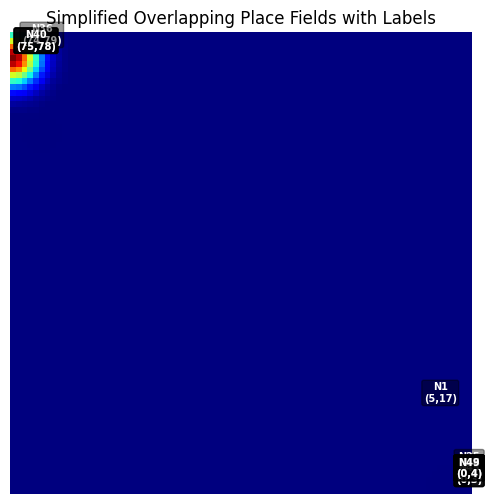

In [6]:
plot_simplified_fields_labeled(fr_maps_all, place_cells, alpha = 0.9)


In [7]:
def plot_combined_place_fields_labeled(fr_maps_all, place_cells, alpha=0.35):
    """
    Overlay all place fields of selected neurons in one 2D grid.
    Adds neuron index and peak (x,y) label on top of its maximum activity.
    """
    plt.figure(figsize=(6,6))
    plt.title("Overlapping 2D Place Fields with Labels")

    for i in place_cells:
        fr_map = np.nan_to_num(fr_maps_all[i])
        # Normalize to [0,1]
        if np.max(fr_map) > 0:
            fr_norm = fr_map / np.max(fr_map)
        else:
            continue

        # Overlay the normalized field
        plt.imshow(np.rot90(fr_norm), origin='lower', cmap='jet', alpha=alpha)

        # Find the peak firing location
        peak_idx = np.unravel_index(np.argmax(fr_map), fr_map.shape)
        x, y = peak_idx  # grid indices (row, col)

        # Text label with neuron number and grid coords
        plt.text(
            y, x, f"N{i}\n({y},{x})",
            color='white',
            fontsize=7,
            ha='center',
            va='center',
            weight='bold'
        )

    plt.axis('off')
    plt.show()


In [8]:
plot_combined_place_fields_labeled(fr_maps_all, place_cells, alpha=0.4, sigma=9)


TypeError: plot_combined_place_fields_labeled() got an unexpected keyword argument 'sigma'